This file is to clearn the TUH EEG seizure data

1. Create a csv file to contains all edf and the labels

2. A class to load data


In [1]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from easydict import EasyDict as edict
import torch
import mne

%matplotlib inline
plt.style.use(FIG_ROOT/"base.mplstyle")

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
from data_utils.eeg_load import montage_txt_parse, EEGData, len2num
from data_utils.sz_utils import txt2labinfo, sz_lab_from_row_fn
from data_utils.utils import get_triple, convert_to_type, rec_data, digitize_data
from utils.misc import load_txt, save_pkl, load_pkl

In [5]:
root = list(DATA_ROOT.glob("EEG_seizure"))[0]
root

PosixPath('/data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../data/EEG_seizure')

# Pre-analysis

# Output csv file

Csv file lists all files

In [14]:
names =["dataset", "sub", 
        "session", "montage", 
        "file_stem", 
        "relative_path", "is_seizure", "total_dur", 
        "lab", "all_chs"]
working_set = "eval" # train, eval, dev 
working_path = root/("edf/"+working_set)

PosixPath('/data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../data/EEG_seizure/edf/eval')

In [15]:
def path2info(p):
    p_dir = "/".join(str(p).split("/")[-5:]).split('.')[0]
    txt = load_txt(p.with_suffix(".csv_bi"))
    infos = txt2labinfo(txt)
    return str(p.parent).split("/")[-4:] \
            + [p.stem]  \
            + [p_dir]  \
            + [infos["is_seizure"]] \
            + [infos["total_dur"]] \
            + [infos["labs"]]

In [16]:
all_infos = []
for p in tqdm(working_path.rglob("*.edf")):
    base_info = path2info(p)
    dat = mne.io.read_raw_edf(p, verbose=False)
    ch_names_simple = [ch_name.split(" ")[-1].split("-")[0].strip() for ch_name in dat.ch_names];
    all_info = base_info + [';'.join(ch_names_simple)]
    all_infos.append(all_info)

865it [00:57, 15.10it/s]


In [17]:
df = pd.DataFrame(all_infos, columns=names)
df.to_csv(root/f"all_data_{working_set}.csv");

In [35]:
df = pd.read_csv(root/f"all_data_{working_set}.csv");

In [39]:
import ast
def _tmp_fn(x):
    v = [vs[1] - vs[0] for 
         vs in ast.literal_eval(x) 
         if vs[2] == "seiz"]
    return v
    
df["lab"].map(_tmp_fn)

0      [449.12120000000004, 6.4848000000001775]
1                                            []
2                                            []
3                                            []
4                                            []
                         ...                   
860                                          []
861                                          []
862                                          []
863                                          []
864                                          []
Name: lab, Length: 865, dtype: object

In [37]:
tmp = df['lab'].iloc[0]

"[(1785.9697, 2235.0909, 'seiz', 1.0), (2267.6061, 2274.0909, 'seiz', 1.0)]"

# Load and split data

In [16]:
all_train = pd.read_csv(root/f"all_data_train.csv", index_col=0);

In [17]:
def split_vec(vec, ratio=0.9):
    vec = np.array(vec)
    true_indices = np.where(vec)[0]
    false_indices = np.where(~vec)[0]

    np.random.shuffle(true_indices)
    np.random.shuffle(false_indices)

    true_count = len(true_indices)
    false_count = len(false_indices)

    true_split = int(true_count * ratio)
    false_split = int(false_count * ratio)

    vec1_indices = np.concatenate((true_indices[:true_split], false_indices[:false_split]))
    vec2_indices = np.concatenate((true_indices[true_split:], false_indices[false_split:]))

    return np.sort(vec1_indices), np.sort(vec2_indices)
seizure_idxs = all_train["is_seizure"]
set1_idxs, set2_idxs = split_vec(seizure_idxs)

In [18]:
set1 = all_train.copy().iloc[set1_idxs]
set2 = all_train.copy().iloc[set2_idxs]
set1 = set1.reset_index(drop=True)
set2 = set2.reset_index(drop=True);
set1.to_csv(root/f"all_data_train_train.csv")
set2.to_csv(root/f"all_data_train_test.csv")

In [19]:
# output data without seizure. 
train_train_data = pd.read_csv(root/f"all_data_train_train.csv", index_col=0)
train_test_data = pd.read_csv(root/f"all_data_train_test.csv", index_col=0);

In [20]:
train_test_health = train_test_data[train_test_data["is_seizure"] == False];
train_test_health = train_test_health.reset_index(drop=True)
train_train_health = train_train_data[train_train_data["is_seizure"] == False];
train_train_health = train_train_health.reset_index(drop=True)

train_test_health.to_csv(root/"all_data_train_test_health.csv")
train_train_health.to_csv(root/"all_data_train_train_health.csv")

In [21]:
# A small training set
train_train_data_health = pd.read_csv(root/f"all_data_train_train_health.csv", index_col=0);
total_num = len(train_train_data_health)
sel_idxs = np.sort(np.random.choice(total_num, size=int(0.1*total_num), replace=False));
train_train_data_health_small = train_train_data_health.iloc[sel_idxs].reset_index(drop=True);
train_train_data_health_small.to_csv(root/"all_data_train_train_health_small.csv")

# Process data and save it

In [14]:
dataset = EEG_data("eval", "ALL", 
                   preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False)
                  );

In [15]:
from tqdm import trange
for ix in trange(len(dataset.all_data)):
    dataset.get_preprocess_data(ix, regen=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 844/844 [10:04<00:00,  1.40it/s]


In [23]:
x =1 

1

# Test

In [10]:
dataset = EEG_data("train", "AR", 
                   move_dict=dict(winsize=1025, stepsize=1024, marginsize=None),
                  preprocess_dict=dict(is_detrend=False, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False));

len(dataset)

176499

In [11]:
from utils.misc import delta_time
import time
train_data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2)
t0 = time.time()
t00 = t0
flag = 1
for ix in train_data_loader:
    print(delta_time(t0))
    t0 = time.time()
    print(f"The average time at iter {flag} is {(t0-t00)/flag:.3f}")
    flag += 1
    

7.035533666610718
The average time at iter 1 is 7.036
2.616145610809326
The average time at iter 2 is 4.826
0.0006456375122070312
The average time at iter 3 is 3.218
0.0013458728790283203
The average time at iter 4 is 2.414
0.00023126602172851562
The average time at iter 5 is 1.931
2.7152321338653564
The average time at iter 6 is 2.062
0.0006005764007568359
The average time at iter 7 is 1.767
1.7349824905395508
The average time at iter 8 is 1.763
0.000629425048828125
The average time at iter 9 is 1.567
0.9406368732452393
The average time at iter 10 is 1.505
0.0005826950073242188
The average time at iter 11 is 1.368
1.3478550910949707
The average time at iter 12 is 1.366
0.0005710124969482422
The average time at iter 13 is 1.261



KeyboardInterrupt



# Remove saved `pkl` file

In [ ]:
working_set = "train" # train, eval and dev
all_data = pd.read_csv(root/f"all_data_{working_set}.csv", index_col=0);
pbar = trange(len(all_data))
nfil = 0
for ix in pbar:
    dat_path = (root/"edf"/all_data["relative_path"].iloc[ix])
    # change the data name
    pkl_fs = list(dat_path.parent.glob("*.pkl"))
    pbar.set_postfix({'n_removed_file': nfil}, refresh=True)
    for pkl_f in pkl_fs:
        if not pkl_f.stem.endswith("90"):
            pass
            print(pkl_f)
        nfil += 1
        pbar.set_postfix({'n_removed_file': nfil}, refresh=True)
        #pkl_f.unlink()

True

# Check the edf data

In [97]:
working_set = "train"
all_data = pd.read_csv(root/f"all_data_{working_set}.csv", index_col=0);
dat_path = (root/"edf"/all_data["relative_path"].iloc[0]).with_suffix(".edf")
dat = mne.io.read_raw_edf(dat_path, verbose=False, preload=True);
dat.filter(l_freq=1, h_freq=45, verbose=False)
dat.resample(90)

<RawEDF | aaaaaaac_s001_t000.edf, 33 x 27090 (301.0 s), ~6.9 MB, data loaded>

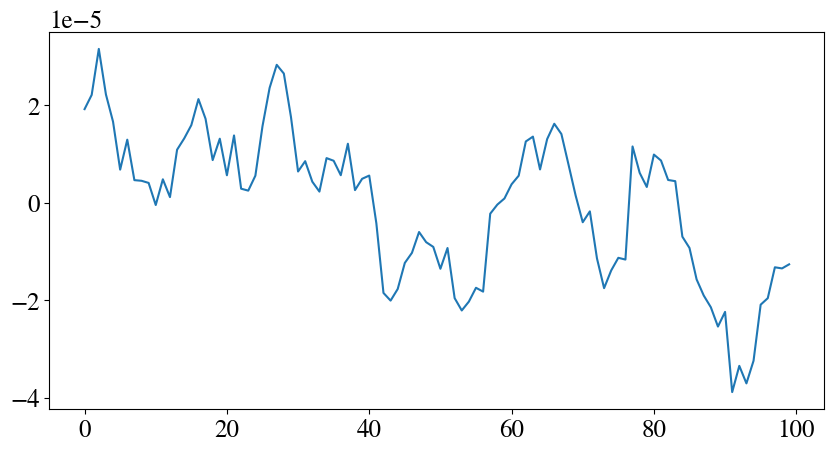

In [99]:
data = dat.get_data();
duration = 100
start = 2000
plt.plot(data[5, start:start+duration])

# Parse seizure onset time info

Test `seiz_lab_fn` and `seiz_lab_from_row_fn` 

In [10]:
all_data = pd.read_csv(root/f"all_data_train.csv", index_col=0);

In [11]:
all_data.head()

,dataset,sub,session,montage,file_stem,relative_path,is_seizure,total_dur,all_chs
0,train,aaaaaaac,s001_2002_12_23,02_tcp_le,aaaaaaac_s001_t000,train/aaaaaaac/s001_2002_12_23/02_tcp_le/aaaaa...,True,301.0,FP1;FP2;F3;F4;C3;C4;A1;A2;P3;P4;O1;O2;F7;F8;T3...
1,train,aaaaaaac,s001_2002_12_23,02_tcp_le,aaaaaaac_s001_t001,train/aaaaaaac/s001_2002_12_23/02_tcp_le/aaaaa...,True,236.0,FP1;FP2;F3;F4;C3;C4;A1;A2;P3;P4;O1;O2;F7;F8;T3...
2,train,aaaaaaac,s002_2002_12_23,02_tcp_le,aaaaaaac_s002_t000,train/aaaaaaac/s002_2002_12_23/02_tcp_le/aaaaa...,True,262.0,FP1;FP2;F3;F4;C3;C4;A1;A2;P3;P4;O1;O2;F7;F8;T3...
3,train,aaaaaaac,s004_2002_12_26,02_tcp_le,aaaaaaac_s004_t000,train/aaaaaaac/s004_2002_12_26/02_tcp_le/aaaaa...,False,321.0,FP1;FP2;F3;F4;C3;C4;A1;A2;P3;P4;O1;O2;F7;F8;T3...
4,train,aaaaaaac,s004_2002_12_26,02_tcp_le,aaaaaaac_s004_t002,train/aaaaaaac/s004_2002_12_26/02_tcp_le/aaaaa...,False,626.0,FP1;FP2;F3;F4;C3;C4;A1;A2;P3;P4;O1;O2;F7;F8;T3...


In [13]:
seiz_lab_from_row_fn(all_data[all_data["is_seizure"]].iloc[5])
#seiz_lab_from_row_fn(all_data.iloc[4])

[(86.0306, 109.6364), (1140.0394, 1185.0722)]

# Data discretization

In [6]:
from data_utils.eeg_load import EEG_data, MyDataLoader
train_data = EEG_data("train_train_health", "AR", 
                      move_dict=dict(winsize=256,
                                     stepsize=256,
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False)
                     )

## minmax check

In [7]:
from data_utils.eeg_load import robust_EEG_rescale

In [8]:
data = train_data["sub1"];
data_minmax = robust_EEG_rescale(data);

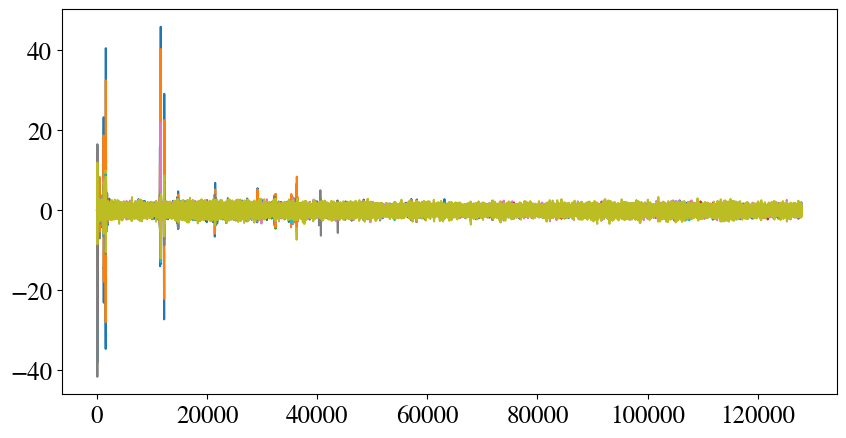

In [9]:
seq_idx = 10
for seq_idx in range(19):
    plt.plot(data_minmax[:, seq_idx])
#plt.ylim([-2, 2])

## Data checking

In [13]:
num_sample_data = 20
all_data = train_data.all_data;
num_cls = 2**8
num_cls_h = (num_cls/2)
qs = np.arange(1, num_cls_h)/num_cls_h;

heal_idxs = np.random.choice(np.arange(len(all_data))[all_data["is_seizure"]==False], size=int(num_sample_data/1));
heal_idxs_test = np.random.choice(np.arange(len(all_data))[all_data["is_seizure"]==False], size=int(num_sample_data/1));

In [14]:
qv = 0.95
vec_heal = np.concatenate([robust_EEG_rescale(train_data[f"sub{idx}"].flatten(), np.quantile(np.abs(train_data[f"sub{idx}"]), [qv])) 
                           for idx in heal_idxs]);
vec_heal_test = np.concatenate([robust_EEG_rescale(train_data[f"sub{idx}"].flatten(), np.quantile(np.abs(train_data[f"sub{idx}"]), [qv])) 
                                for idx in heal_idxs_test]);
vec_heal_abs = np.abs(vec_heal);
vec_heal_test_abs = np.abs(vec_heal_test);
cut_heal = np.quantile(vec_heal_abs, qs)
cut_heal_test = np.quantile(vec_heal_test_abs, qs)

diff1 = np.abs(cut_heal - cut_heal_test)/(cut_heal+cut_heal_test)/2;
cut_heal1 = cut_heal;

In [15]:
qv = 0.998
vec_heal = np.concatenate([
    robust_EEG_rescale(train_data[f"sub{idx}"].flatten(), np.quantile(np.abs(train_data[f"sub{idx}"]), [qv])) 
    #robust_EEG_rescale(train_data[f"sub{idx}"].flatten(), np.abs(train_data[f"sub{idx}"]).max())
                           for idx in heal_idxs]);
vec_heal_test = np.concatenate([
    robust_EEG_rescale(train_data[f"sub{idx}"].flatten(), np.quantile(np.abs(train_data[f"sub{idx}"]), [qv])) 
    #robust_EEG_rescale(train_data[f"sub{idx}"].flatten(), np.abs(train_data[f"sub{idx}"]).max())
                                for idx in heal_idxs_test]);
vec_heal_abs = np.abs(vec_heal);
vec_heal_test_abs = np.abs(vec_heal_test);
cut_heal = np.quantile(vec_heal_abs, qs)
cut_heal_test = np.quantile(vec_heal_test_abs, qs)

diff2 = np.abs(cut_heal - cut_heal_test)/(cut_heal+cut_heal_test)/2;
cut_heal2 = cut_heal;

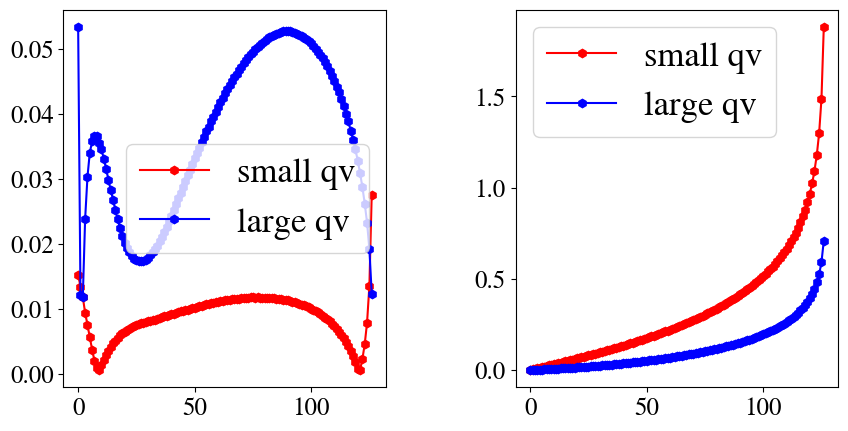

In [16]:
plt.subplot(121)
plt.plot(diff1, "h-r", label="small qv")
plt.plot(diff2, "h-b", label="large qv")
plt.legend()

plt.subplot(122)
plt.plot(cut_heal1, "h-r", label="small qv")
plt.plot(cut_heal2, "h-b", label="large qv")
plt.legend()

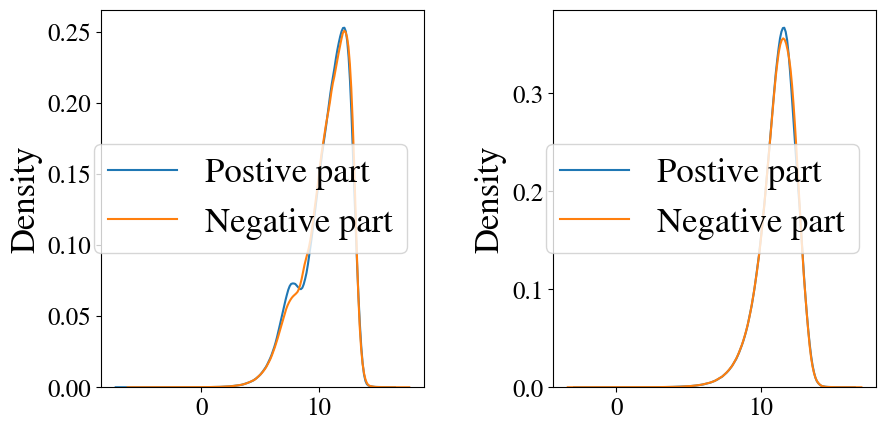

In [171]:
# the data are overall sym around 0 (not need to run)
sns.kdeplot(np.log(vec_heal[vec_heal>=0]), label="Postive part")
sns.kdeplot(np.log(np.abs(vec_heal[vec_heal<0])), label="Negative part")
plt.legend()

## Generate cutoffs and save

In [10]:
train_data = EEG_data("train_train_health", "AR", 
                      move_dict=dict(winsize=256,
                                     stepsize=256,
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False),
                     scale_fct=None)

In [11]:
# only get the cuts on the healthy data
num_sample_data = 40
all_data = train_data.all_data;

heal_idxs = np.random.choice(np.arange(len(all_data))[all_data["is_seizure"]==False], size=int(num_sample_data/1));

vec_uni = np.concatenate([
    train_data[f"sub{idx}"].flatten()
    #robust_EEG_rescale(train_data[f"sub{idx}"].flatten())
                          for idx 
                          in heal_idxs]);
vec_uni_abs = np.abs(vec_uni);

/home/hujin/jin/conda/envs/eeg-sz-det/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 2.0)

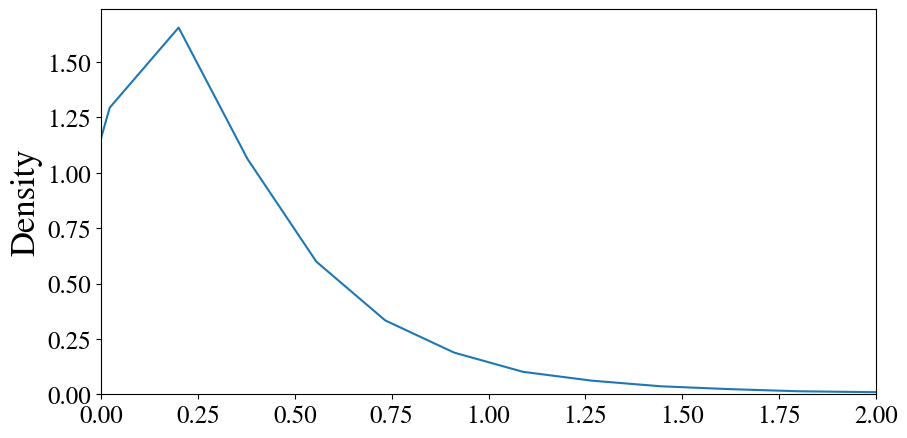

In [12]:
sel_idxs = np.random.choice(vec_uni_abs.shape[0], size=10000);
sns.kdeplot(vec_uni_abs[sel_idxs])
plt.xlim([0, 2])

In [13]:
# save the cuts
k = 5 #num_cls = 2**k
for k in range(5, 13):
    num_cls_h = 2**(k-1)
    qs = np.arange(1, num_cls_h)/num_cls_h;
    cuts = np.quantile(vec_uni_abs, qs)
    
    save_pkl(root/f"discrete_cuts/cuts_2power{k}_rescale_health.pkl", cuts, is_force=True)
    print(cuts[-2:])

/data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts
Create a folder /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts
Save to /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts/cuts_2power5_rescale_health.pkl
[0.66869173 0.91404309]
Save to /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts/cuts_2power6_rescale_health.pkl
[0.91404309 1.19762933]
Save to /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts/cuts_2power7_rescale_health.pkl
[1.19762933 1.55008923]
Save to /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts/cuts_2power8_rescale_health.pkl
[1.55008923 2.03875368]
Save to /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../da

## Discretize the data

In [51]:
k = 8
data = train_data["sub8"];
data_discrete = digitize_data(data, k, True);
data_rec = rec_data(data_discrete, k, True);
#cutoffs = load_pkl(root/f"discrete_cuts/cuts_2power{k}_rescale_health.pkl");
#cutoffs_full = np.sort(np.concatenate([-cutoffs, [0], cutoffs]));

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts/cuts_2power8_rescale_health.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts/cuts_2power8_rescale_health.pkl


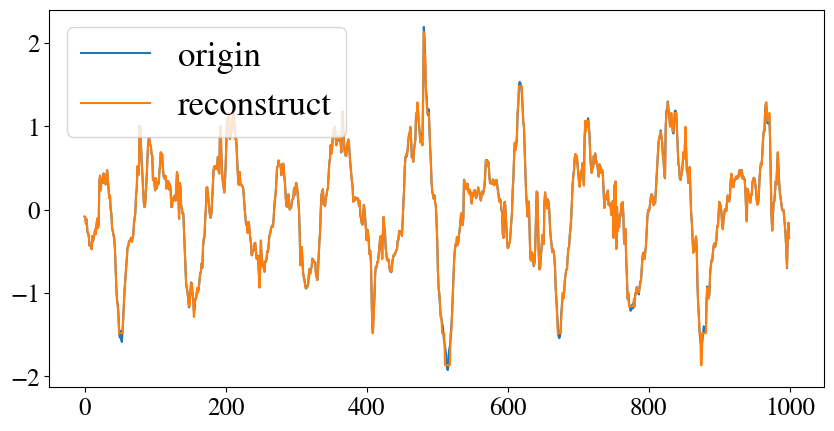

In [52]:
seq_idx = 1
seq_org = data[:1000, seq_idx]
seq_dis = data_discrete[:1000, seq_idx];
seq_rec = data_rec[:1000, seq_idx];

plt.plot(seq_org, label="origin")
plt.plot(seq_rec, label="reconstruct")
plt.legend()

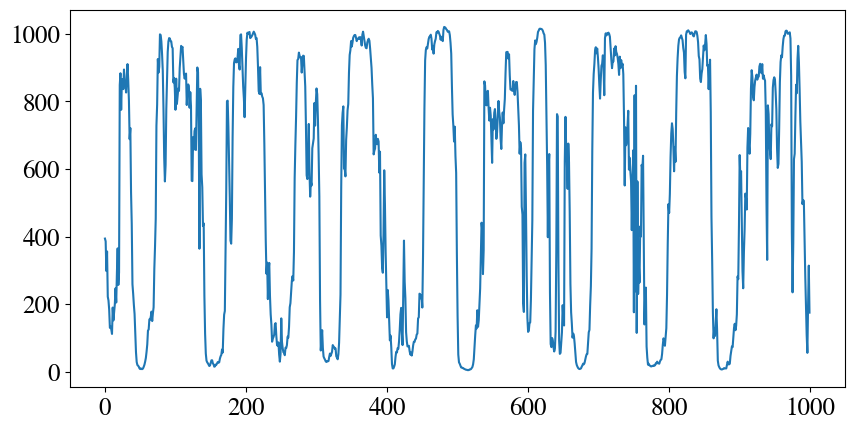

In [49]:
plt.plot(seq_dis)